## Multi-label classification

In [42]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
from fastai.conv_learner import *

In [44]:
PATH = 'data/planet/'

In [45]:
# Data preparation steps if you are using Crestle:

# os.makedirs('data/planet/models', exist_ok=True)
# os.makedirs('/cache/planet/tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

In [46]:
!ls {PATH}

__MACOSX		    test-jpg.tar		  train-jpg.tar
models			    test-jpg.tar.7z		  train-jpg.tar.7z
test-jpg		    test_v2_file_mapping.csv	  train_v2.csv
test-jpg-additional	    test_v2_file_mapping.csv.zip  train_v2.csv.zip
test-jpg-additional.tar     tmp
test-jpg-additional.tar.7z  train-jpg


## Multi-label versus single-label classification

In [47]:
from fastai.plots import *

In [48]:
def get_1st(path): return glob(f'{path}/*.*')[0]

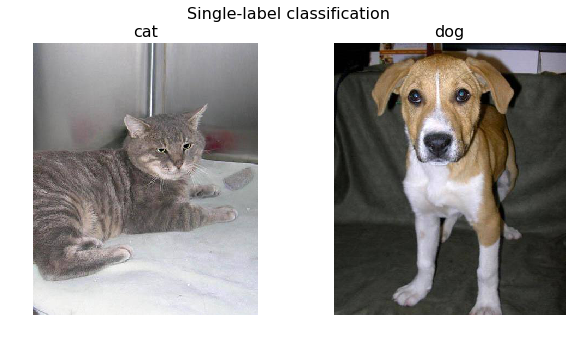

In [49]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

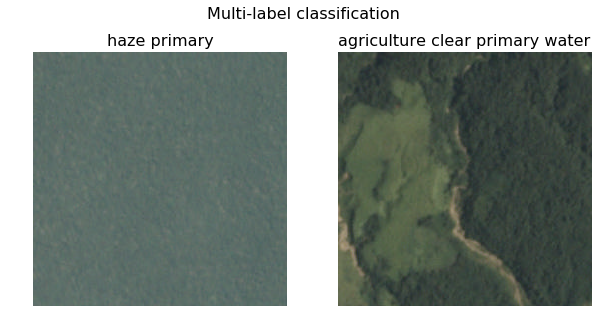

In [50]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [51]:
from planet import f2

metrics=[f2]
f_model = resnet34

**f2** =  f_betas false negatives and false postitives much word where beta = 2, weight

In [52]:
# ??f2

In [53]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

Here we'll have 8 flips. 90, 180, 270, and 0 degree, and same for the side. We'll also have some rotation, zooming, contrast, and brightness adjustments.

data.val_ds returns single item/image, say data.val_ds[0]

data.val_dl retuns a generator, which returns mini-batch of items/images. We always get the next mini-batch

In [54]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [55]:
data = get_data(256)

In [56]:
x,y = next(iter(data.val_dl))# dl is data_loader, data_loader gives you the mini-batch
#x is the images, and y is the labels. returns the next mini-batch of data

In [57]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [58]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

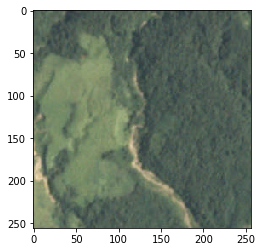

In [59]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4); 

#### How do we use this?

**resize the data from 256 down to 64**

wouldn't do this for cats and dogs, because it starts off nearly perfect. If we resized, we destroy the model. Most ImageNet models are designed around 224 which was close to the normal. In this case, since this is landscape, thereisn't that much of ImageNet that is useful for satellite

In [60]:
sz=64

In [61]:
data = get_data(sz)

##### What does resize do?

I will not use images more than image size 1.3, go ahead and make new jpg where the smallest edge is x size. so this will save a lot of time for processing. Ingeneral the image resize will take a center crop.

In [62]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

##### Train model

**note:**L training implies improving filters/kernels and weights in Fully connected layers. On the other hand activations are caculated.

In [63]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [66]:
learn.summary() # if this doesn't work, run the following command first

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
        

##### Search for Learning Rate

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.225715   0.31572    0.788581  



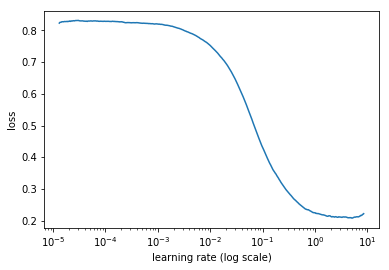

In [65]:
lrf=learn.lr_find()
learn.sched.plot()

In [67]:
lr = 0.2

##### Refit the model

In [68]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.149712   0.138452   0.876616  
    1      0.14125    0.132178   0.882537                    
    2      0.141425   0.129442   0.886848                    
    3      0.142092   0.128472   0.889193                    
    4      0.136107   0.126194   0.888769                    
    5      0.135979   0.12563    0.889322                    
    6      0.134612   0.124664   0.891131                    



[0.12466443, 0.8911310423334508]

##### How are the learning rates spread per layer?
[split halfway, splot halfwary, always last layer only]?

In [69]:
lrs = np.array([lr/9,lr/3,lr])

In [70]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.11974    0.110709   0.906478  
    1      0.116546   0.105484   0.910235                    
    2      0.107546   0.102327   0.913711                    
    3      0.112904   0.104853   0.911601                    
    4      0.105456   0.099673   0.916828                    
    5      0.101692   0.098518   0.917323                     
    6      0.097828   0.097925   0.917344                     



[0.09792481, 0.9173437395764183]

In [71]:
learn.save(f'{sz}')

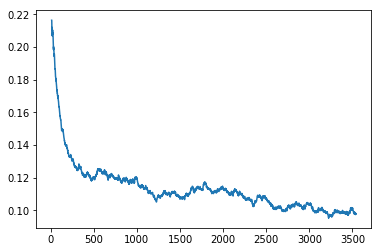

In [72]:
learn.sched.plot_loss()

###### change to a bigger size, using only the last layer's learning rate to retrain the model, then unfreeze the layers and apply differentiate LRs

In [73]:
sz=128

In [74]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.099603   0.095823   0.917256  
    1      0.095468   0.094339   0.919435                     
    2      0.096086   0.093943   0.918626                     
    3      0.097151   0.093152   0.919691                     
    4      0.096265   0.093344   0.919956                     
    5      0.09409    0.092299   0.920573                     
    6      0.095205   0.092483   0.920609                     



[0.092483476, 0.9206091620478092]

In [76]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.09417    0.087952   0.926423  
    1      0.095216   0.087409   0.927848                     
    2      0.088544   0.08511    0.928952                     
    3      0.09206    0.087675   0.928579                     
    4      0.088118   0.085455   0.928727                     
    5      0.081789   0.084605   0.92909                      
    6      0.081376   0.084996   0.928826                     



##### change to an even bigger size, and retrain the model

In [77]:
sz=256

In [78]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.090408   0.089539   0.924101  
    1      0.090421   0.088456   0.926579                     
    2      0.089137   0.088058   0.926462                     
    3      0.089798   0.088421   0.92507                      
    4      0.08802    0.087689   0.925973                     
    5      0.088223   0.087724   0.925972                     
    6      0.087299   0.087404   0.926367                     



[0.08740443, 0.9263670387781139]

In [79]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.086078   0.083241   0.931448  
    1      0.089306   0.083916   0.931262                     
    2      0.080089   0.082113   0.9323                       
    3      0.087139   0.086299   0.927396                     
    4      0.082357   0.083187   0.931522                     
    5      0.082109   0.08189    0.932758                     
    6      0.078433   0.081643   0.932559                     



In [80]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [81]:
f2(preds,y)

0.9308576474567988

### End